In [1]:
from sys import exit

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Reshape, Dropout
from keras.models import Model

2021-11-08 19:32:01.374735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-08 19:32:01.374803: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
img_rows = img_cols = 28
show_k = not True  # False True
pred = True
mnist = True
pathToData = 'mnist/' if mnist else 'emnist/'
num_classes = 10 if mnist else 27
epochs = 40
fn_model = pathToData + 'lk3.h5'
#
pathToHistory = 'mnist/' if mnist else 'emnist/'
suff = '.txt'
# Имена файлов, в которые сохраняется история обучения
fn_loss = pathToHistory + 'loss_' + suff
fn_acc = pathToHistory + 'acc_' + suff
fn_val_loss = pathToHistory + 'val_loss_' + suff
fn_val_acc = pathToHistory + 'val_acc_' + suff

In [12]:
def show_x(x, img_rows, img_cols, N):
    n = int(np.sqrt(N))
    for i, j in enumerate(np.random.randint(1000, size=n * n)):
        plt.subplot(n, n, i + 1)
        # Убираем 3-е измерение
        plt.imshow(x[j].reshape(img_rows, img_cols), cmap='gray')
        plt.axis('off')
    plt.show()

In [13]:
def one_plot(n, y_lb, loss_acc, val_loss_acc):
    plt.subplot(1, 2, n)
    if n == 1:
        lb, lb2 = 'loss', 'val_loss'
        yMin = 0
        yMax = 1.05 * max(max(loss_acc), max(val_loss_acc))
    else:
        lb, lb2 = 'acc', 'val_acc'
        yMin = min(min(loss_acc), min(val_loss_acc))
        yMax = 1.0
    plt.plot(loss_acc, color='r', label=lb, linestyle='--')
    plt.plot(val_loss_acc, color='g', label=lb2)
    plt.ylabel(y_lb)
    plt.xlabel('Эпоха')
    plt.ylim([0.95 * yMin, yMax])
    plt.legend()
# 
def loadBinData(pathToData, img_rows, img_cols):
    print('Загрузка данных из двоичных файлов...')
    with open(pathToData + 'imagesTrain.bin', 'rb') as read_binary:
        x_train = np.fromfile(read_binary, dtype=np.uint8)
    with open(pathToData + 'labelsTrain.bin', 'rb') as read_binary:
        y_train = np.fromfile(read_binary, dtype=np.uint8)
    with open(pathToData + 'imagesTest.bin', 'rb') as read_binary:
        x_test = np.fromfile(read_binary, dtype=np.uint8)
    with open(pathToData + 'labelsTest.bin', 'rb') as read_binary:
        y_test = np.fromfile(read_binary, dtype=np.uint8)
    # Преобразование целочисленных данных в float32 и нормализация; данные лежат в диапазоне [0.0, 1.0]
    x_train = np.array(x_train, dtype='float32') / 255
    x_test = np.array(x_test, dtype='float32') / 255
    x_train = x_train.reshape(-1, img_rows, img_cols)
    x_test = x_test.reshape(-1, img_rows, img_cols)
    # Преобразование в категориальное представление: метки - числа из диапазона [0, 9] в двоичный вектор размера num_classes
    # Так, в случае MNIST метка 5 (соответствует классу 6) будет преобразована в вектор [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
    # print(y_train[0]) # (MNIST) Напечатает: 5
    print('Преобразуем массивы меток в категориальное представление')
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    # print(y_train[0]) # (MNIST) Напечатает: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    return x_train, y_train, x_test, y_test

In [14]:
x_train, y_train, x_test, y_test = loadBinData(pathToData, img_rows, img_cols)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
if show_k:
    show_x(x_test, img_rows, img_cols, 16)
    exit()
#
# Определяем форму входных данных
input_shape = (img_rows, img_cols, 1)

# x_shape = img_rows * img_cols

# x_train = x_train.reshape(-1, x_shape)
# x_test = x_test.reshape(-1, x_shape)

# Создание модели нейронной сети
model = keras.Sequential() 
model.add(Flatten(input_shape=input_shape)) 
# model.add(Reshape(target_shape=(img_rows * img_cols,), input_shape=input_shape)) 
# model.add(keras.Input(x_shape)) 
model.add(Dense(256, activation='relu')) 
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

Загрузка данных из двоичных файлов...
Преобразуем массивы меток в категориальное представление
(60000, 28, 28) (60000, 10) (10000, 28, 28) (10000, 10)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
def ch(i):
    return str(chr(ord('A')+i-1))

def test_compile():
    from keras.models import load_model

    model = load_model(fn_model)
    # Оценка модели НС на тестовых данных
    score = model.evaluate(x_test, y_test)
    # Вывод потерь и точности
    print('Потери при тестировании:', round(score[0], 4))
    print('Точность при тестировании: {}{}'.format(score[1] * 100, '%'))
    # Прогноз
    y_pred = model.predict(x_test)
    # print(y_pred[0])
    # print(y_test[0])
    # [6.8e-6 1.5e-10 7.6e-6 1.5e-3 7.0e-9 6.2e-5 2.2e-11 9.9e-1 3.0e-7 5.9e-6]
    # [0.     0.      0.     0.     0.     0.     0.      1.     0.     0.]
    # Заносим в массив predicted_classes метки классов, предсказанных моделью НС
    predicted_classes = np.array([np.argmax(m) for m in y_pred])
    true_classes = np.array([np.argmax(m) for m in y_test])
    n_test = len(y_test)
    # Число верно классифицированных изображений
    true_classified = np.sum(predicted_classes == true_classes)
    # Число ошибочно классифицированных изображений
    false_classified = n_test - true_classified
    acc = 100.0 * true_classified / n_test
    print('Точность: {}{}'.format(acc, '%'))
    print('Неверно классифицированно:', false_classified)
    m, m_max = 0, 15
    lst_false = []
    print('  Индекс  | Прогноз | Правильный класс')
    for i in range(n_test):
        cls_pred = predicted_classes[i]  # Предсказанное моделью имя класса
        cls_true = true_classes[i]  # Истинное имя класса
        if cls_pred != cls_true:
            m += 1
            lst_false.append([i, cls_pred, cls_true])
            if (m == min(m_max, false_classified)): break
            print('  {:5d}   |    {}    |    {}'.format(i, ch(cls_pred), ch(cls_true)))
    plt.figure('Ошибки классификации')
    for k in range(len(lst_false)):
        plt.subplot(3, 5, k + 1)
        lst = lst_false[k]
        plt.imshow(x_test[lst[0]].reshape(img_rows, img_cols), cmap='gray')
        plt.title('{}/{}'.format(ch(lst[1]), ch(lst[2])))
        plt.axis('off')
    plt.show()

In [16]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 
# Обучение нейронной сети 
history = model.fit(x_train, y_train, epochs=epochs, batch_size=128,
                    verbose=1, validation_data=(x_test, y_test))
model.save(fn_model)
print('Модель сохранена в файле', fn_model)
# Запись истории обучения в текстовые файлы 
history = history.history
##for itm in history.items(): print(itm) 
with open(fn_loss, 'w') as output:
    for val in history['loss']: output.write(str(val) + '\n')
with open(fn_acc, 'w') as output:
    for val in history['accuracy']: output.write(str(val) + '\n')
with open(fn_val_loss, 'w') as output:
    for val in history['val_loss']: output.write(str(val) + '\n')
with open(fn_val_acc, 'w') as output:
    for val in history['val_accuracy']: output.write(str(val) + '\n')
 

2021-11-08 19:40:21.379438: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/40
469/469 [==============================] - 2s 4ms/step - loss: 0.3099 - accuracy: 0.9132 - val_loss: 0.1628 - val_accuracy: 0.9515
Epoch 2/40
469/469 [==============================] - 2s 4ms/step - loss: 0.1325 - accuracy: 0.9617 - val_loss: 0.1164 - val_accuracy: 0.9656
Epoch 3/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0918 - accuracy: 0.9735 - val_loss: 0.0988 - val_accuracy: 0.9706
Epoch 4/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0689 - accuracy: 0.9804 - val_loss: 0.0798 - val_accuracy: 0.9757
Epoch 5/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0519 - accuracy: 0.9851 - val_loss: 0.0720 - val_accuracy: 0.9763
Epoch 6/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0408 - accuracy: 0.9881 - val_loss: 0.0659 - val_accuracy: 0.9792
Epoch 7/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0321 - accuracy: 0.9916 - val_loss: 0.0659 - val_accuracy: 0.9804
Epoch 

650/650 [==============================] - 1s 878us/step - loss: 0.3290 - accuracy: 0.9043
Потери при тестировании: 0.329
Точность при тестировании: 90.42788743972778%
Точность: 90.42788461538461%
Неверно классифицированно: 1991
  Индекс  | Прогноз | Правильный класс
     21   |    Q    |    A
     33   |    Q    |    A
     41   |    Z    |    A
     44   |    U    |    A
     51   |    Q    |    A
     68   |    Q    |    A
     76   |    G    |    A
     90   |    Q    |    A
    119   |    Z    |    A
    128   |    O    |    A
    143   |    O    |    A
    201   |    Z    |    A
    203   |    M    |    A
    207   |    C    |    A


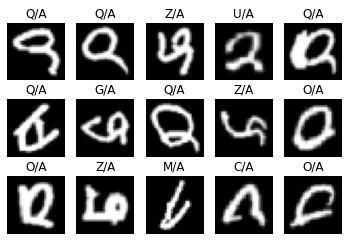

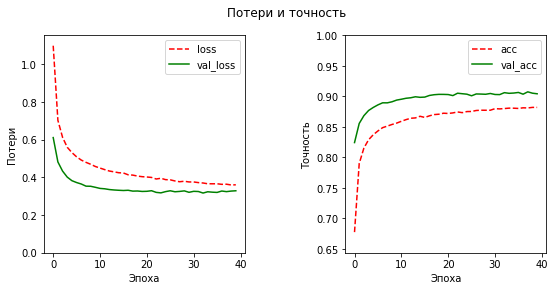

In [9]:
   
if pred:
    test_compile()    
    
# Вывод графиков обучения 
plt.figure(figsize=(9, 4))
plt.subplots_adjust(wspace=0.5)
one_plot(1, 'Потери', history['loss'], history['val_loss'])
one_plot(2, 'Точность', history['accuracy'], history['val_accuracy'])
plt.suptitle('Потери и точность')
plt.show()

(20800, 784)
[[5.99575186e-13 7.58547544e-01 1.00598186e-01 1.02411623e-05
  9.11231153e-03 6.10341194e-05 1.13824128e-04 1.22090540e-04
  5.84734976e-02 1.49395346e-05 2.42404731e-05 5.45044568e-05
  6.36968571e-06 2.18346482e-03 2.59955376e-02 1.12522449e-02
  1.06170652e-02 2.47014159e-05 2.25076973e-02 7.47823506e-05
  7.63734261e-06 7.75160443e-05 6.27958943e-05 1.19839851e-05
  2.93204557e-05 1.17567670e-05 4.64582854e-06]]
1


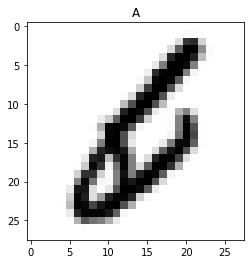

In [10]:
print(x_test.shape)
n = 10
x = np.expand_dims(x_test[n], axis=0)
res = model.predict(x)
print( res )
mx = np.argmax(res)
print( mx )

plt.title(str(chr(ord('A')+mx-1)))
plt.imshow(np.reshape(x_test[n], (img_rows, img_cols)), cmap=plt.cm.binary)
plt.show()